# FastFarmInterface: an MPI-based Python-FastFarm interface to develop wind farm control policies 

## Prerequisites

This notebook needs to be run on the WFCRL Interface kernel. If you have not installed the kernel, you can do so by uncommenting the lines in the cell below to execute the following code:

```
from wfcrl import jupyter_utils
jupyter_utils.create_ipykernel()
```


In [5]:
# UNCOMMENT TO INSTALL WFCRL Kernel
#from wfcrl import jupyter_utils
#jupyter_utils.create_ipykernel()

Once the WFCRL Interface kernel is installed, click on your kernel on the upper right of your notebook and select `WFCRL Interface`. You might need to refresh your page first.
![kernel_selection](../docs/chose_wfcrl_kernel.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from wfcrl.environments import data_cases as cases
from wfcrl.interface import FastFarmInterface
from wfcrl.simul_utils import create_ff_case
from wfcrl.environments import FastFarmCase

sns.set_theme(style="darkgrid")

## Farm configuration

In the following, it is assumed that you have a local FastFarm executable. Start by updating the path to this `exe` file below.

In [2]:
FAST_FARM_EXECUTABLE = "simulators/fastfarm/bin/FAST.Farm_x64_OMP_2023.exe"

The library comes with a list of pre-existing farm layouts that can be found in `environments/data_cases.py` and uses directly to create an interface:

In [3]:
config = cases.fastfarm_6t
ff_interface = FastFarmInterface.from_case(
    config,
    fast_farm_executable=FAST_FARM_EXECUTABLE
    #output_dir="path_to_output_dir"
)

Created FAST.Farm input file: C:\Users\bizonmoc\Documents\Projects\WFCRL\wfcrl\simulators\fastfarm\inputs/FarmInputs/Case.fstf


Alternatively, you can create your own layout with `FastFarmCase` and use `create_ff_case` to create all the configuration files needed to run FAST.Farm.

In [4]:
config = FastFarmCase(
    num_turbines=3,
    xcoords=[0.0, 504.0, 1008.0],
    ycoords=[0.0, 0.0, 0.0],
    dt=3,
    max_iter = 200,
    t_init=1,
)
fstf_file = create_ff_case(config.dict(), output_dir="examples")

Created FAST.Farm input file: examples/FarmInputs/Case.fstf


Then, make the FAST.Farm interface with the created file or your own `.fstf`.

In [6]:
ff_interface = FastFarmInterface.from_file(
    fstf_file=fstf_file,
    fast_farm_executable=FAST_FARM_EXECUTABLE
)

Simulation will be started from fstf file examples/FarmInputs/Case.fstf
Creating new DLLs for simulation examples/FarmInputs/Case.fstf


c:\Users\bizonmoc\Documents\Projects\WFCRL\wfcrl\simul_utils.py:64: UserWarning: A supercontroler DLL already exists in C:\Users\bizonmoc\Documents\Projects\WFCRL\examples\servo_dll\SC_DLL.dll.It will not be replaced.
  warnings.warn(
c:\Users\bizonmoc\Documents\Projects\WFCRL\wfcrl\simul_utils.py:80: UserWarning: A controler DLL already exists in C:\Users\bizonmoc\Documents\Projects\WFCRL\examples\5MW_Baseline\ServoData\DISCON_WT1.dllIt will not be replaced.
  warnings.warn(
c:\Users\bizonmoc\Documents\Projects\WFCRL\wfcrl\simul_utils.py:80: UserWarning: A controler DLL already exists in C:\Users\bizonmoc\Documents\Projects\WFCRL\examples\5MW_Baseline\ServoData\DISCON_WT2.dllIt will not be replaced.
  warnings.warn(
c:\Users\bizonmoc\Documents\Projects\WFCRL\wfcrl\simul_utils.py:80: UserWarning: A controler DLL already exists in C:\Users\bizonmoc\Documents\Projects\WFCRL\examples\5MW_Baseline\ServoData\DISCON_WT3.dllIt will not be replaced.
  warnings.warn(


The case under these conditions corresponds to a layout of 3 NREL 5MW turbines with a steady inflow of 8m/s at 90m and a direction of 270°. All the needed files to start a FAST.Farm simulation can be found in the folder `examples`.

## Start simulation

To change the yaw, pitch or torque command, use the method `update_command(yaw, pitch, torque)`. Let's change the first yaw and pitch angle at the 100th iteration:

In [7]:
ff_interface.init()
raw_measures, avg_wind, avg_powers = [], [], []
for i in range(ff_interface.max_iter):
    print("PYTHON: Iter ", i)
    yaw_command = np.zeros(ff_interface.num_turbines, dtype=np.double)
    pitch_command = np.zeros(ff_interface.num_turbines, dtype=np.double)
    if i > 100:
        yaw_command[0] = 30 #in degrees
        pitch_command[0] = 1 #in degrees
    ff_interface.update_command(yaw=yaw_command, pitch=pitch_command)
    print(f"Iter {i} - Sent command YAW {ff_interface.get_yaw_command()} - "
          f" PITCH {ff_interface.get_pitch_command()}"
          f" TORQUE {ff_interface.get_torque_command()}\n"
          f" Received Power: {ff_interface.last_powers().flatten()}"
          f" Wind : {ff_interface.last_wind().flatten()}\n"
    )
    raw_measures.append(ff_interface.get_all_measures())
    avg_powers.append(ff_interface.avg_powers(window=30))
    avg_wind.append(ff_interface.avg_wind(window=30))

Spawning process simulators/fastfarm/bin/FAST.Farm_x64_OMP_2023.exe examples/FarmInputs/Case.fstf
Interface: will receive 12 measures at every iteration
PYTHON: Iter  0
Iter 0 - Sent command YAW [0. 0. 0.] -  PITCH [0. 0. 0.] TORQUE None
 Received Power: [1605662.5 1605662.5 1605662.5] Wind : [  7.99831104 270.        ]

PYTHON: Iter  1
Iter 1 - Sent command YAW [0. 0. 0.] -  PITCH [0. 0. 0.] TORQUE None
 Received Power: [1665929.75  1665929.625 1665929.75 ] Wind : [  7.99831104 270.        ]

PYTHON: Iter  2
Iter 2 - Sent command YAW [0. 0. 0.] -  PITCH [0. 0. 0.] TORQUE None
 Received Power: [1686899.375 1686899.    1686899.375] Wind : [  7.99831104 270.        ]

PYTHON: Iter  3
Iter 3 - Sent command YAW [0. 0. 0.] -  PITCH [0. 0. 0.] TORQUE None
 Received Power: [1692948.    1692947.875 1692948.   ] Wind : [  7.99831104 270.        ]

PYTHON: Iter  4
Iter 4 - Sent command YAW [0. 0. 0.] -  PITCH [0. 0. 0.] TORQUE None
 Received Power: [1696833.375 1696833.    1696833.375] Wind : [ 

## Plots and data

All the measurements are available with the method `get_all_measures()` and stored in `raw_measures` in our case.

In [8]:
ff_interface.get_all_measures()

,wind_speed,power,wind_direction,yaw,pitch,torque,load_0,load_1,load_2,load_3,load_4,load_5
0,7.998311,1132822.875,0.000000,29.998785,1.0,14051.687500,3654420.5,4836918.00,4148716.25,2549877.25,-2962332.00,1.720423e+06
1,6.306458,1040271.125,-9.854180,-0.000025,0.0,13069.408203,5202407.0,3645631.75,4154858.50,-2363110.00,3419097.75,1.599687e+05
2,5.091401,617779.500,-5.792669,-0.000585,0.0,8270.120117,3311321.0,4219426.00,2899558.50,1501065.00,-3100931.00,2.370696e+06


In [9]:
df = pd.concat(raw_measures)
df["iter"] = np.arange(df.shape[0]) // ff_interface.num_turbines
df["turbine"] = df.index

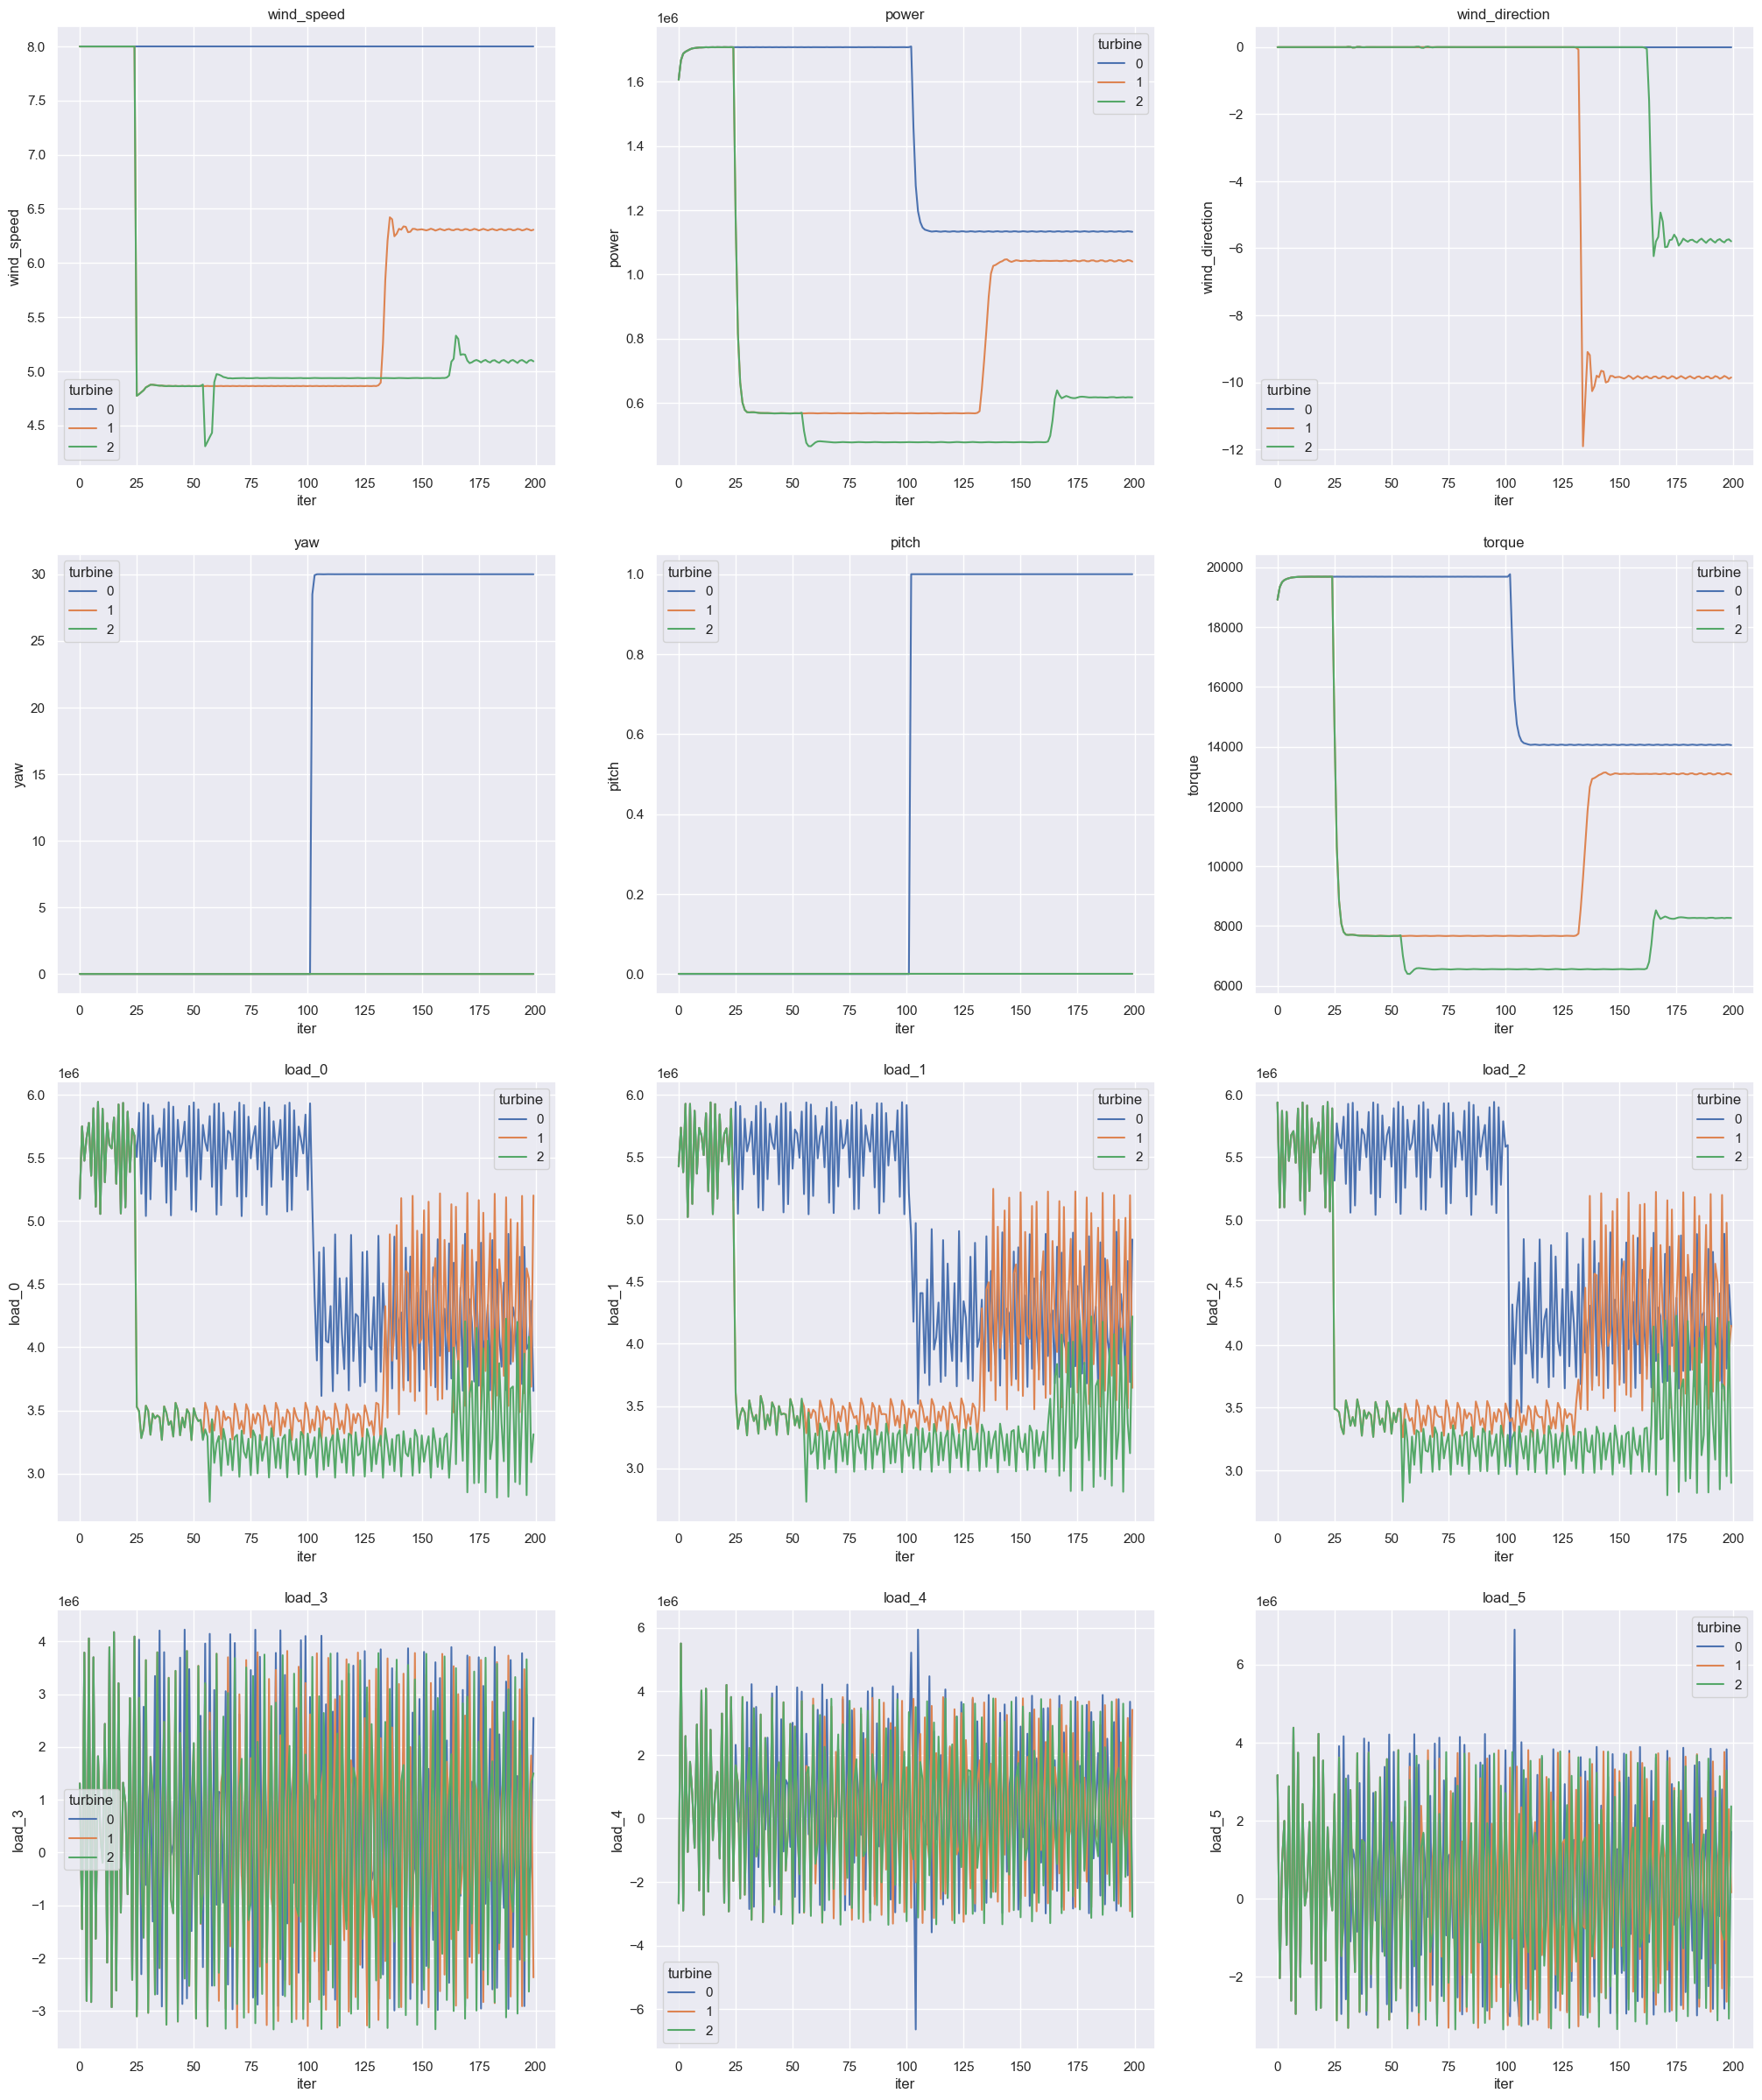

In [10]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(25,30))
for axitem, name in zip(ax.flatten(), df.columns):
    sns.lineplot(df, x="iter", y=name, hue="turbine", ax=axitem, palette="deep")
    axitem.set_title(name)

`FastFarmInterface` can automatically average measurements for the powers, wind speed and wind_direction, which can be accesses via the `avg_powers(window)` and `avg_wind(window)` methods, where `window` is the averaging window in samples. The `last_powers()` and `last_wind()` methods return respectively all turbine powers and the wind measurements at the entrance of the farm, which includes the wind speed in m/s and the wind direction from the North in degrees.

Text(0.5, 1.0, 'Wind Direction from North (°)')

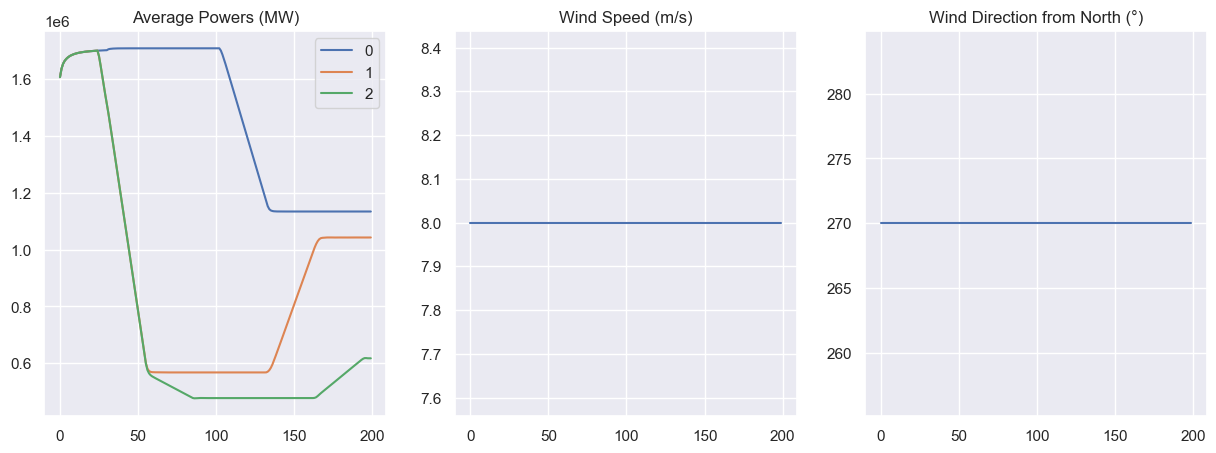

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
pd.DataFrame(avg_powers).plot(ax=ax[0])
wind_array = np.array(avg_wind)
ax[0].set_title("Average Powers (MW)")
sns.lineplot(wind_array[:, 0], ax=ax[1])
ax[1].set_title("Wind Speed (m/s)")
sns.lineplot(wind_array[:, 1]).plot(ax=ax[2])
ax[2].set_title("Wind Direction from North (°)")